# LAMA into the Wild Part1: DataPreperation

# 1. Overview

In this section We will preprocess the Data that we needed in the whole program. The result will be stored in `../data/pre`

In [ ]:
import os
import gc
import typing as t
import logging

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data import DATA_DIR
from lama.util import to_tuple, identity
from lama.util.decorators import enable_logging
from lama.util.StreamerBuilder import StreamerBuilder
from lama.preprocessing.DataProcessor import nans, change_object_col, reformat_dataframe, split_with_index, standarize_col

# 1.1 Define Global Constants

To make our reading and writing more easier, we decide to define some global constants below, you can change them if you'd like to write to another location.

In [40]:
OUT_DIR = os.path.join(DATA_DIR, "pre")
logger = logging.getLogger('root')

The process looks alike, we will handle them one by one.

- filter out Nan values
- check unique columns
- convert object values to numericals
- catagorize discrete and continous features
- scaling columns with Standardizer or Normalizer. 

# 2. Exploratory Data Analysis

# 2.1 Train and Test

We will first handle train and test dataset.

In [41]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), header=0, parse_dates= ["first_active_month"])
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), header=0, parse_dates= ["first_active_month"])

In [42]:
df_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [43]:
df_test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


Test dataset does not have target value unlike train dataset.

In [44]:
print(f'The shape of the train: {df_train.shape}')
print('*'*20)
print(f'The shape of the test: {df_test.shape}')

The shape of the train: (201917, 6)
********************
The shape of the test: (123623, 5)


Let's check any null values in datasets.

In [45]:
# check nans
print(f'df_test nans: \n{nans(df_test)}\n')
print('*'*20)
print(f'df_train nans: \n{nans(df_train)}\n')

df_test_copy = df_test.copy()

df_test nans: 
first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

********************
df_train nans: 
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64



First_active month feature has null values in the test dataset.

Let's check if there is abnormal distribution in train dataset.

unexpected value: 2207


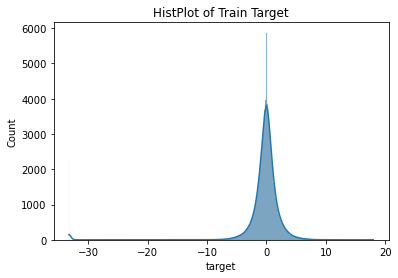

In [46]:
sns.histplot(df_train['target'], kde=True).set(title="HistPlot of Train Target")
unexpected = (df_train['target'] < -30).sum()
print(f'unexpected value: {unexpected}')

Clearly there exists some unexpected values when target < -30.
One more thing to notice is the distribution is symmetric to 0. Let's check the distribution of the target class without unexpected values.

[Text(0.5, 1.0, 'HistPlot of Train Target')]

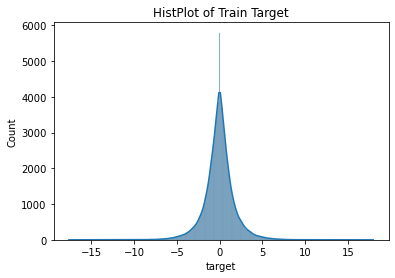

In [47]:
df_train_copy = df_train[df_train['target'] > -30]
sns.histplot(df_train_copy['target'], kde=True).set(title="HistPlot of Train Target")

Then we check if the id is unique, this procedure is important as we might need to outer join other datasets with id.

In [48]:
train_count = df_train_copy.shape[0]
test_count = df_test_copy.shape[0]
print(df_train_copy['card_id'].nunique() == train_count)
print(df_test_copy['card_id'].nunique() == test_count)

True
True


It shows that all card ids are unique in train and test datasets.

In [49]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199710 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  199710 non-null  datetime64[ns]
 1   card_id             199710 non-null  object        
 2   feature_1           199710 non-null  int64         
 3   feature_2           199710 non-null  int64         
 4   feature_3           199710 non-null  int64         
 5   target              199710 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 10.7+ MB


In [50]:
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  123622 non-null  datetime64[ns]
 1   card_id             123623 non-null  object        
 2   feature_1           123623 non-null  int64         
 3   feature_2           123623 non-null  int64         
 4   feature_3           123623 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.7+ MB


card_id feature has 'object' datatype. Since the card_id is a foreign key bound to match more features in other dataset, we'll leave it intact.

In [51]:

# features = ['first_active_month']
# df_temps = reformat_dataframe(df_test_copy.append(df_train_copy), features, change_object_col)
# df_test_copy, df_train_copy = to_tuple(split_with_index(df_temps, test_count))
# del df_temps

Let's check datasets again.
We would like to see if the train and test features are evenly split.

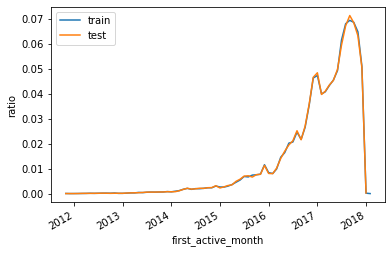

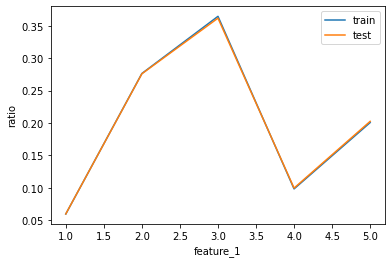

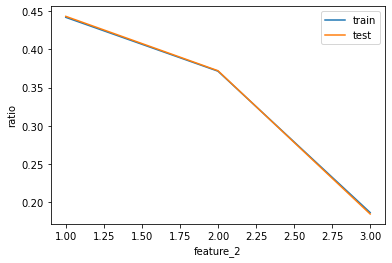

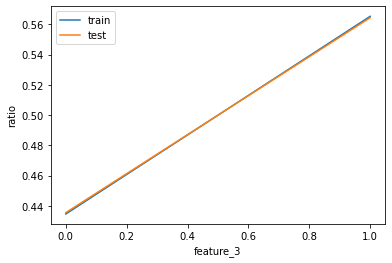

In [52]:
features = ['first_active_month', 'feature_1', 'feature_2', 'feature_3']
for feature in features:
    (df_train_copy[feature].value_counts().sort_index() / train_count).plot()
    (df_test_copy[feature].value_counts().sort_index() / test_count).plot()
    plt.legend(['train', 'test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

There is no difference in the train and test distributions. It shows that they are distributed similarly in each feature.

## 2.1.1 Distribution of the anonymize features

### 2.1.1.1 Bar plot of the anonymize features

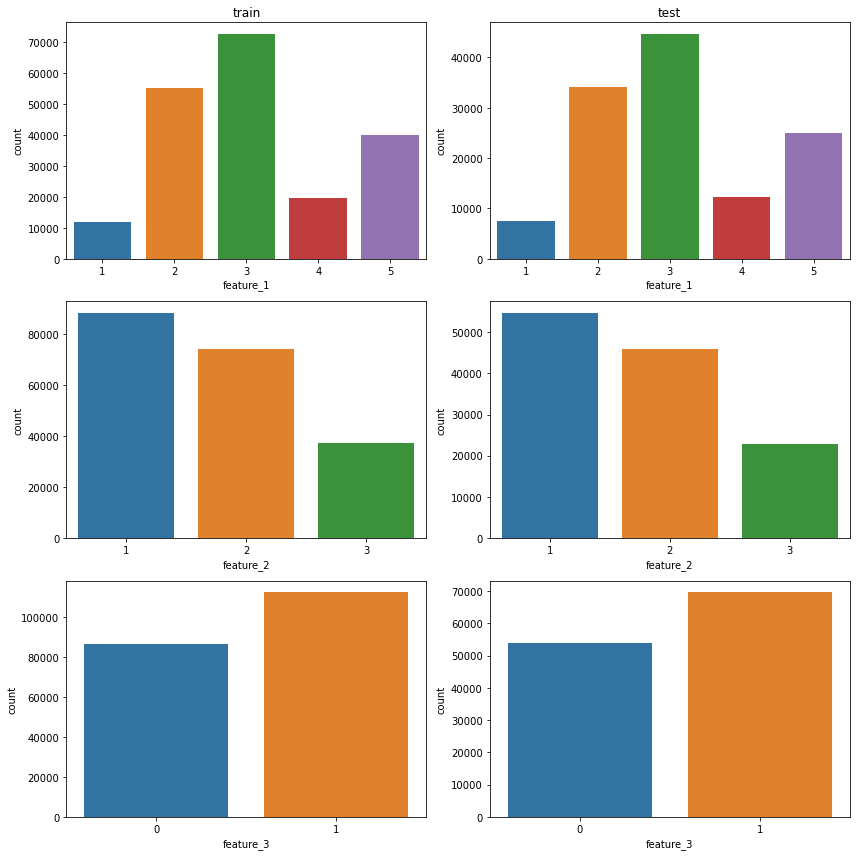

In [53]:
def plot_discrt_many_barplot(dflist, dataset_names, feature_names):
    """

    Args:
        dflist (list[pd.Dataframe]): list of datasets to show bar plot
        dataset_names (list[str]): name of the datasets
        feature_names (list(str): name of the features which are plotted of the dataset

    """
    n_rows = len(feature_names)
    n_cols = len(dflist)
    fig, axes = plt.subplots(nrows= n_rows, ncols= n_cols, figsize = (12,12))
    for ax, colm in zip(axes[0], dataset_names):
        ax.set_title(colm)
    for i in range(n_cols):
        for j in range(n_rows):
            sns.countplot(x = feature_names[j], data= dflist[i], ax = axes[j, i])
    fig.tight_layout()
    plt.show()

def plot_discret_barplot(df:pd.DataFrame, dataset_name:str, feature_names):
    n_rows = len(feature_names)
    fig, axes = plt.subplots(nrows= n_rows, ncols= 1, figsize = (8, 6))
    coordinate_subplot = n_rows*100 + 11 # n_rows x 1 x 1
    for i in range(n_rows):
        plt.subplot(coordinate_subplot)
        column = feature_names[i]
        types = dict(df.dtypes)
        if types[column] == object:
            unique_values = df[column].unique()
            sns.countplot(x = column, data = df, order = unique_values)
        else:
            sns.countplot(x = column, data = df)
        coordinate_subplot += 1
    fig.tight_layout()
    plt.show()

names_dataset = ['train', 'test']
features = ['feature_1', 'feature_2', 'feature_3']
plot_discrt_many_barplot([df_train_copy, df_test_copy], names_dataset, features)

Bars of the train and test datasets shows that feature_1, features_2, features_3 are categorical data, and they are distributed similarly. Let's investigate relation of these features with target.

## 2.1.1.2 Anonymous features with Target

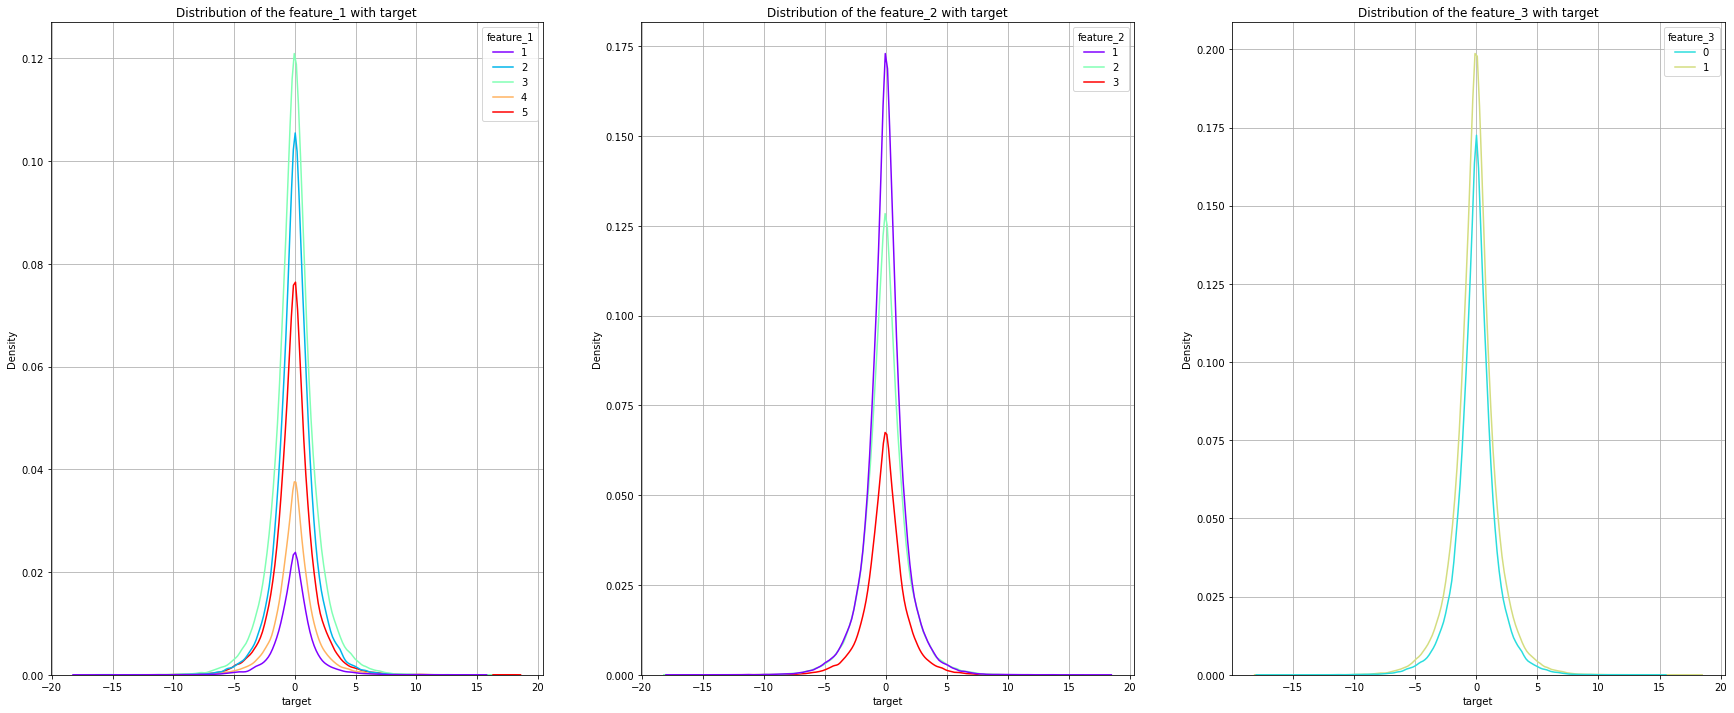

In [54]:
def plot_density_with_target(dataset : pd.DataFrame, feature_names, target:str):
    """
    Args:
        dataset (pd.DataFrame): list of datasets to show density plot with target
        feature_names (list(str): name of the features which are plotted of the dataset
        target (str) : target class of the dataset

    """
    n_features = len(feature_names)
    plt.figure(figsize=(30,12))
    plot_place = 131;
    for i in range(n_features):
        plt.subplot(plot_place)
        sns.kdeplot(x = target, data= dataset, hue = feature_names[i], palette='rainbow')
        plt.title(f'Distribution of the {feature_names[i]} with target')
        plt.grid()
        plot_place += 1
    plt.show()

plot_density_with_target(df_train_copy, features, 'target')

As we see, distribution of the target class with respect to anonymize features does not differ from each other and is symmetric to zero value. Thus, these features does not give good information to predict values. Furthermore, mean of the target values of each this category is zero. The data may be mean standardized.

### 2.1.2 Distribution of the feature first_active_month

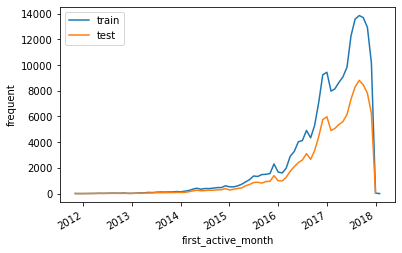

In [55]:
def plot_line(df_list, x_feature: str, legend):

    for df in df_list:
        df[x_feature].value_counts().sort_index().plot()
    plt.legend(legend)
    plt.xlabel(x_feature)
    plt.ylabel("frequent")
    plt.show()
feature = 'first_active_month'
legends = ['train', 'test']
plot_line([df_train_copy, df_test_copy], feature, legends)

First purchase are made between 2011 and 2018. It is made mostly between 2016 and 2018. However, there exists a sharp decrease in 2018.

In [56]:
year_train = pd.DatetimeIndex(df_train_copy['first_active_month']).year
year_test = pd.DatetimeIndex(df_test_copy['first_active_month']).year
print(year_train.value_counts())
print("*"*20)
print(year_test.value_counts())

2017    129523
2016     50461
2015     13888
2014      4418
2013      1104
2012       271
2018        35
2011        10
Name: first_active_month, dtype: int64
********************
2017.0    79990
2016.0    31395
2015.0     8605
2014.0     2755
2013.0      691
2012.0      153
2018.0       28
2011.0        5
Name: first_active_month, dtype: int64


In 2018 there exists sharp decline in the number of first purchase, because we have only 35 samples in 2018.
Let's explore this feature with target.

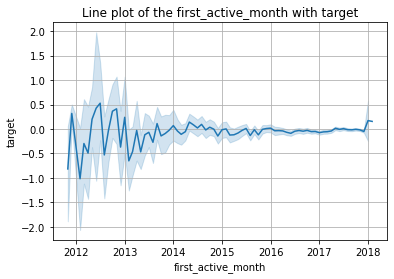

In [57]:
def plot_lineplot_with_another(df:pd.DataFrame, x_feature:str, y_feature:str):
    sns.lineplot(data= df, x= x_feature, y= y_feature)
    plt.title('Line plot of the ' + x_feature + ' with ' + y_feature)
    plt.grid()
    plt.show()
target = 'target'
plot_lineplot_with_another(df_train_copy, feature, target)

The plot shows that target class behaves like a damping frequency of the plot.

### 2.1.3 Correlation between features in train dataset

Firstly, we will look at scatter plot matrix of the train.

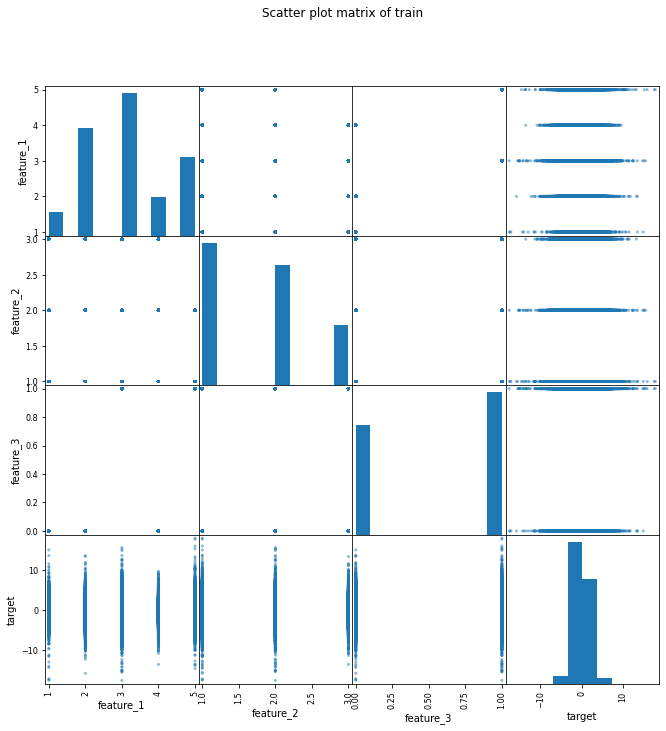

In [58]:
from pandas.plotting import scatter_matrix
def plot_scatter_matrix(df: pd.DataFrame, dataset_name):
    scatter_size = 11
    scatter_matrix(df, figsize = (scatter_size, scatter_size))
    plt.suptitle("Scatter plot matrix of " + dataset_name)
    plt.show()
plot_scatter_matrix(df_train_copy, 'train')

It seems that there is no correlation between features. We can also look at heatmap of the features.

,feature_1,feature_2,feature_3,target
feature_1,1.000000,-0.130098,0.582980,-0.010884
feature_2,-0.130098,1.000000,0.059928,-0.003607
feature_3,0.582980,0.059928,1.000000,-0.007330
target,-0.010884,-0.003607,-0.007330,1.000000


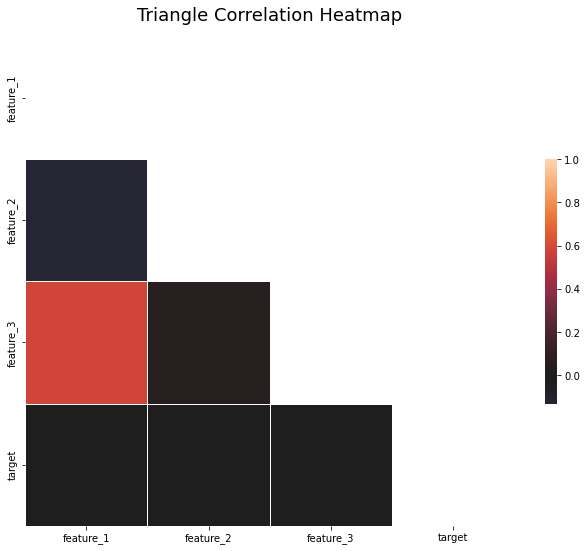

In [59]:
def plot_heatmap(df:pd.DataFrame):
    """
    Plots the correlation matrix and shows correlation between features.
    Args:
        df: dataset whose correlation matrix will be shown
    Returns:

    """
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

plot_heatmap(df_train_copy)
df_train_copy.corr()

There is a moderate relationship between feature_1 and feature_3.

Now we need to standarize the features, since not every model need standarized data, we will just leave the builder here uncollected.  

In [60]:
# builder = StreamerBuilder.build([df_test_copy, df_train_copy]) \
#     .map(lambda df: reformat_dataframe(df, features, standarize_col))

In [61]:
df_train_copy.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


Last step is to write the result back, and fetch when we needed.

In [62]:
df_test_copy.to_csv(os.path.join(OUT_DIR, 'test_pre.csv'), index=False)
df_train_copy.to_csv(os.path.join(OUT_DIR, 'train_pre.csv'), index=False)

del df_test, df_test_copy, df_train, df_train_copy, features, test_count, train_count, unexpected


# 2.2 Merchant Data purge

Now we will have a look at merchants.csv

In [ ]:
df_merchant_org = pd.read_csv(os.path.join(DATA_DIR, 'merchants.csv'), header=0)
df_merchant = df_merchant_org.copy()
df_merchant.head()

In [97]:
print(f'The shape of the merchant: {df_merchant.shape}')

The shape of the merchant: (334696, 22)


In [98]:
df_merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

In [99]:
print (df_merchant.shape[0], df_merchant['merchant_id'].nunique())
nans(df_merchant)


334696 334633


merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

Obviously, there exists some merchant whose id appears multiple times in this dataset. In category_2 lacks a significant amount of datas. We will check the unique value from category 4 to see if it is possible to replace nans to 0

We will change the object columns to numerical ones.

In [100]:


merchants_category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
                 'subsector_id', 'category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'city_id', 'state_id', 'category_4', 'category_2']

merchants_numeric_cols = ['numerical_1', 'numerical_2', 'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
                'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']

assert len(merchants_numeric_cols) + len(merchants_category_cols) == len(df_merchant.columns)

check category columns unique values

In [101]:
print(df_merchant[merchants_category_cols].nunique())
print('*'*20)
print(df_merchant[merchants_category_cols].dtypes)
print('*'*20)
print(df_merchant['category_2'] .unique())

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
city_id                           271
state_id                           25
category_4                          2
category_2                          5
dtype: int64
********************
merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
city_id                          int64
state_id                         int64
category_4                      object
category_2                     float64
dtype: object
********************
[ 1.  5. nan  2.  3.  4.]


In [102]:

df_merchant['category_2'].fillna(-1, inplace=True)
cols = ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']
df_merchant = reformat_dataframe(df_merchant, cols, change_object_col)
df_merchant[df_merchant['category_2'] == -1]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,1,4,4,NaN,...,NaN,4.666667,6,NaN,3.833333,12,1,-1,-1,-1.0
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,1,4,4,NaN,...,NaN,0.361111,6,NaN,0.347222,12,1,-1,-1,-1.0
7,M_ID_d8ff08219e,16430,529,20,-0.057471,-0.057471,1,4,4,NaN,...,NaN,1.666667,6,NaN,1.500000,11,1,-1,-1,-1.0
9,M_ID_d2162ed113,112122,81,29,-0.057471,-0.057471,1,4,4,NaN,...,NaN,1.000000,2,NaN,1.000000,2,1,-1,-1,-1.0
11,M_ID_73487fed26,17123,427,27,-0.057471,-0.057471,1,4,4,NaN,...,NaN,inf,6,NaN,inf,12,1,-1,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334686,M_ID_3111c6df35,107283,690,1,-0.057471,-0.057471,1,0,0,0.95,...,0.90,0.967786,6,0.79,0.891154,12,1,-1,-1,-1.0
334688,M_ID_59764e8cb1,17285,309,21,0.329211,-0.057471,1,0,0,0.97,...,1.00,1.107380,6,1.05,1.120891,12,1,-1,-1,-1.0
334690,M_ID_a9d91682ad,35,241,17,-0.057471,-0.057471,1,0,0,0.96,...,0.85,0.919159,6,0.90,0.982781,12,1,-1,-1,-1.0
334692,M_ID_725a60d404,35,544,29,-0.057471,-0.057471,1,0,0,0.89,...,0.78,0.813473,6,0.59,0.606765,12,1,-1,-1,-1.0


In [103]:
print(df_merchant[merchants_numeric_cols].dtypes)
print('*'*20)
print(nans(df_merchant))
print('*'*20)
df_merchant.describe()

numerical_1            float64
numerical_2            float64
avg_sales_lag3         float64
avg_purchases_lag3     float64
active_months_lag3       int64
avg_sales_lag6         float64
avg_purchases_lag6     float64
active_months_lag6       int64
avg_sales_lag12        float64
avg_purchases_lag12    float64
active_months_lag12      int64
dtype: object
********************
merchant_id                     0
merchant_group_id               0
merchant_category_id            0
subsector_id                    0
numerical_1                     0
numerical_2                     0
category_1                      0
most_recent_sales_range         0
most_recent_purchases_range     0
avg_sales_lag3                 13
avg_purchases_lag3              0
active_months_lag3              0
avg_sales_lag6                 13
avg_purchases_lag6              0
active_months_lag6              0
avg_sales_lag12                13
avg_purchases_lag12             0
active_months_lag12             0
category_4  

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,3.346960e+05,...,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.832993,inf,...,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489999,NaN,...,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,-82.130000,3.334953e-01,...,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,9.236499e-01,...,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667e+00,...,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522e+00,...,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,inf,...,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000,1.000000,347.000000,24.000000,5.000000


As it is seen, there exists infinity values in dataset. It is most likely caused by if last month transaction is zero, because it is calculated by monthly average of transaction in last 3,6 or 12 months divided by transaction in last active month. We can replace infinity values with the second-largest values.

In [104]:
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']

# replace infinity with second-values
df_merchant = reformat_dataframe(df_merchant, inf_cols, lambda df: df.replace(np.inf, df[df != np.inf].max()))
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,334696.000000,...,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.832993,2.145143,...,2.165079e+01,2.390194,5.947397,2.522771e+01,2.529277,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489999,213.955844,...,3.947108e+03,194.324264,0.394936,5.251842e+03,174.419034,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,-82.130000,0.333495,...,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,0.923650,...,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667,...,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522,...,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,61851.333333,...,1.513959e+06,56077.500000,6.000000,2.567408e+06,50215.555556,12.000000,1.000000,347.000000,24.000000,5.000000


Now we do not see any infinite values anymore.

#Fill nans with mean values

In [73]:
# df_merchant = reformat_dataframe(df_merchant, merchants_numeric_cols, lambda df: df.fillna(df.mean()))
# nans(df_merchant)


merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
dtype: int64

## 2.2.1 Exploring numerical_1 and numerical_2 Features

In [105]:
numerical_features = ["numerical_1", "numerical_2"]
merchant_name = 'merchant'
print(df_merchant[numerical_features].describe())
print('*'*30)
for col in numerical_features:
    print(f'{col} : {df_merchant[col].nunique()}')

         numerical_1    numerical_2
count  334696.000000  334696.000000
mean        0.011476       0.008103
std         1.098154       1.070497
min        -0.057471      -0.057471
25%        -0.057471      -0.057471
50%        -0.057471      -0.057471
75%        -0.047556      -0.047556
max       183.735111     182.079322
******************************
numerical_1 : 954
numerical_2 : 947


As seen, first quantile, second and third quartile of these numerical features are same. Furthermore, they have only almost 941 unique values. We can compare the features by visualising.

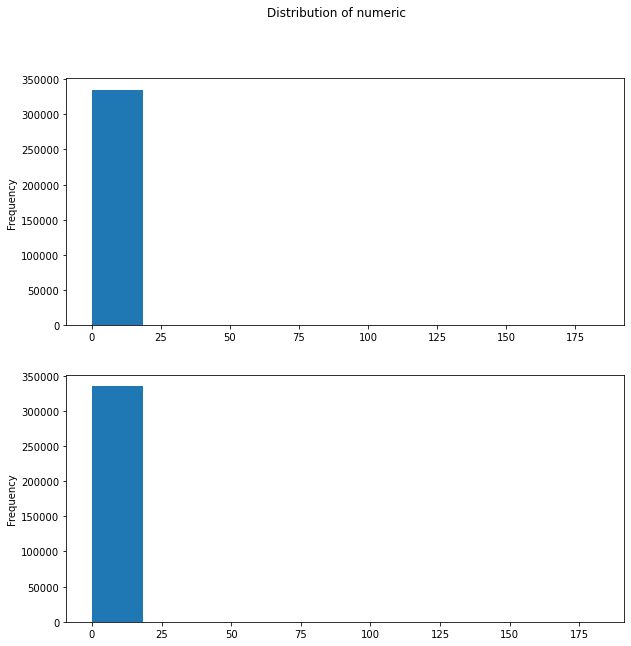

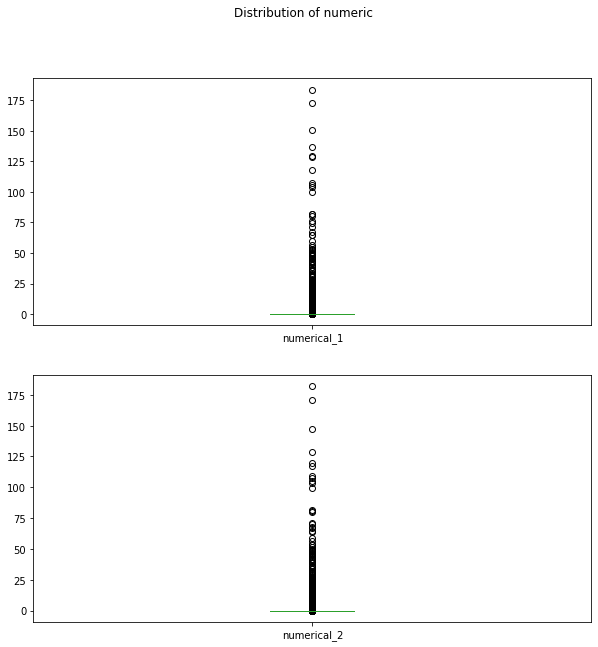

In [106]:
def plot_cont_histogram(df:pd.DataFrame, features_names, with_log :bool = False):
    n_rows = len(features_names)
    plt.figure(figsize=(10,10))
    coord_pos = 100 * n_rows + 11 # n_rows x 1 x 1
    for i in range(n_rows):
        plt.subplot(coord_pos)
        column = features_names[i]
        sns.histplot(df[column], log_scale= with_log, kde= True)
        coord_pos += 1
    plt.tight_layout()
    plt.show()


def plot_withkind(df:pd.DataFrame, kind:str, title:str, feature_names, is_sorted:bool = False):
    length = len(feature_names)
    n_cols = 1
    n_rows = length
    fig, ax = plt.subplots(nrows= n_rows, ncols= n_cols, figsize = (10, 10))
    if is_sorted:
        for i in range(length):
            column = feature_names[i]
            df[column].value_counts().sort_index().plot(kind = kind, ax = ax[i], title = column)
    else:
        for i in range(length):
            column = feature_names[i]
            df[column].plot(kind = kind, ax= ax[i])
    plt.suptitle('Distribution of '+ title)


kind_plot = 'hist'
title_plot= 'numeric'
plot_withkind(df_merchant, kind_plot, title_plot, numerical_features)

kind_plot = 'box'
plot_withkind(df_merchant, kind_plot, title_plot, numerical_features)

The distribution of the numerical_1 and numerical_2 features looks identical.

### 2.2.2 Exploring anonymize category_1, 2 and 4 features

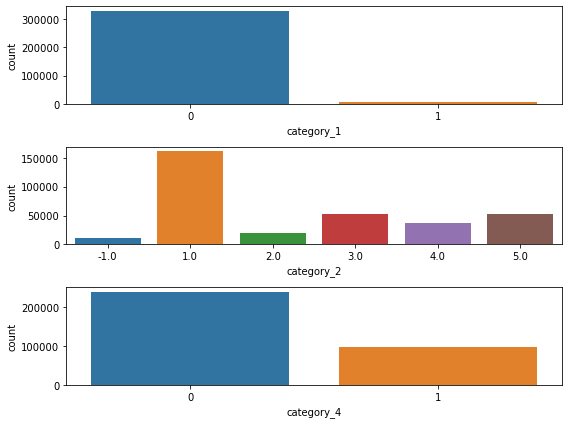

In [107]:
m_categories = ['category_1', 'category_2', 'category_4']
plot_discret_barplot(df_merchant, merchant_name, m_categories)

All three features are categorical data and represent some anonymize features of the merchants.

### 2.2.3 Exploring sales averages

In [108]:
m_sales_features = ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']
print(df_merchant[m_sales_features].describe())

       avg_sales_lag3  avg_sales_lag6  avg_sales_lag12
count   334683.000000    3.346830e+05     3.346830e+05
mean        13.832993    2.165079e+01     2.522771e+01
std       2395.489999    3.947108e+03     5.251842e+03
min        -82.130000   -8.213000e+01    -8.213000e+01
25%          0.880000    8.500000e-01     8.500000e-01
50%          1.000000    1.010000e+00     1.020000e+00
75%          1.160000    1.230000e+00     1.290000e+00
max     851844.640000    1.513959e+06     2.567408e+06


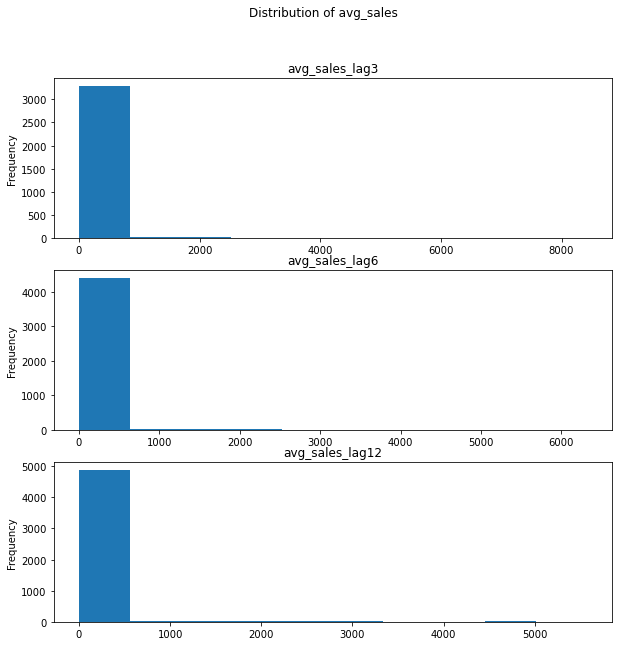

In [109]:
kind_plot = 'hist'
title_plot = 'avg_sales'
plot_withkind(df_merchant, kind_plot, title_plot, m_sales_features, True)

In [110]:
m_evaluated_feature = 'avg_sales_lag3'
mean = df_merchant[m_evaluated_feature].mean()
std = df_merchant[m_evaluated_feature].std()
print(df_merchant[df_merchant[m_evaluated_feature] > (mean + 3*std)].count())
df_merchant[df_merchant[m_evaluated_feature] > (mean + 3*std)]

merchant_id                    19
merchant_group_id              19
merchant_category_id           19
subsector_id                   19
numerical_1                    19
numerical_2                    19
category_1                     19
most_recent_sales_range        19
most_recent_purchases_range    19
avg_sales_lag3                 19
avg_purchases_lag3             19
active_months_lag3             19
avg_sales_lag6                 19
avg_purchases_lag6             19
active_months_lag6             19
avg_sales_lag12                19
avg_purchases_lag12            19
active_months_lag12            19
category_4                     19
city_id                        19
state_id                       19
category_2                     19
dtype: int64


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
16,M_ID_c929bb59af,9514,2,20,-0.057471,-0.057471,0,4,4,69667.00,...,69667.00,1.000000,3,69667.00,1.000000,3,0,-1,20,5.0
19,M_ID_7551d55443,16010,298,10,-0.057471,-0.057471,0,4,4,109733.00,...,118433.00,19.000000,6,217857.00,35.416667,12,0,282,18,2.0
21,M_ID_39643c7d93,22146,309,21,-0.057471,-0.057471,0,4,4,608433.00,...,776683.00,7.000000,6,749804.00,6.000000,12,0,-1,16,1.0
22,M_ID_07930b58ae,11559,705,33,-0.057471,-0.057471,0,4,4,148515.00,...,245840.00,134.833333,6,272061.00,151.454545,11,0,123,19,3.0
23,M_ID_e16b20b50a,35,511,7,-0.057471,-0.057471,0,4,4,385833.00,...,464184.00,183.666667,6,460206.00,184.333333,9,0,126,4,4.0
24,M_ID_0f0334c393,39020,437,15,-0.057471,-0.057471,0,4,4,205863.00,...,1513959.00,33.666667,6,2567408.00,61.166667,12,0,272,9,1.0
26,M_ID_0fa16b39ed,35,781,7,-0.057471,-0.057471,0,4,4,44436.00,...,93735.00,17.500000,4,93735.00,17.500000,4,0,140,9,1.0
27,M_ID_69618a786a,4760,703,29,-0.057471,-0.057471,0,4,4,360107.00,...,646764.00,37.333333,6,683700.00,39.818182,11,0,62,9,1.0
28,M_ID_3c87a47f6b,38953,703,29,-0.057471,-0.057471,0,4,4,624741.00,...,953792.00,329.166667,6,827191.00,283.833333,12,0,60,16,1.0
29,M_ID_c44ccc8110,4274,278,37,-0.057471,-0.057471,0,4,4,133863.00,...,133859.00,67.500000,4,133859.00,67.500000,4,1,143,5,5.0


These features have outliers.

In [111]:
m_purchase_features = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']
print(df_merchant[m_purchase_features].describe())

       avg_purchases_lag3  avg_purchases_lag6  avg_purchases_lag12
count       334696.000000       334696.000000        334696.000000
mean             2.145143            2.390194             2.529277
std            213.955844          194.324264           174.419034
min              0.333495            0.167045             0.098330
25%              0.923650            0.902247             0.898333
50%              1.016667            1.026961             1.043361
75%              1.146522            1.215575             1.266480
max          61851.333333        56077.500000         50215.555556


The distribution of the avg_sales_lag3,6,12 looks very similar, and they have outliers.

In [112]:
mean = df_merchant['avg_purchases_lag3'].mean()
std = df_merchant['avg_purchases_lag3'].std()
print(df_merchant[df_merchant['avg_purchases_lag3'] > (mean + 3*std)].count())
df_merchant[df_merchant['avg_purchases_lag3'] > (mean + 3*std)]

merchant_id                    14
merchant_group_id              14
merchant_category_id           14
subsector_id                   14
numerical_1                    14
numerical_2                    14
category_1                     14
most_recent_sales_range        14
most_recent_purchases_range    14
avg_sales_lag3                 10
avg_purchases_lag3             14
active_months_lag3             14
avg_sales_lag6                 10
avg_purchases_lag6             14
active_months_lag6             14
avg_sales_lag12                10
avg_purchases_lag12            14
active_months_lag12            14
category_4                     14
city_id                        14
state_id                       14
category_2                     14
dtype: int64


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
10,M_ID_492cfa500c,13462,369,27,-0.057471,-0.057471,0,4,4,NaN,...,NaN,56077.500000,6,NaN,50215.555556,12,0,-1,9,1.0
11,M_ID_73487fed26,17123,427,27,-0.057471,-0.057471,1,4,4,NaN,...,NaN,56077.500000,6,NaN,50215.555556,12,1,-1,-1,-1.0
12,M_ID_7149162139,2118,63,27,-0.057471,-0.057471,0,4,4,NaN,...,NaN,56077.500000,6,NaN,50215.555556,12,1,88,16,1.0
15,M_ID_c9855bf3e3,321,690,1,-0.057471,-0.057471,1,4,4,NaN,...,NaN,3432.666667,6,NaN,5236.000000,12,1,-1,-1,-1.0
235,M_ID_7ce96c351a,35,302,22,-0.057471,-0.057471,0,4,4,851844.64,...,770443.34,56077.500000,6,689561.85,50215.555556,9,1,69,9,1.0
653,M_ID_cd558a87be,13449,451,7,-0.057471,-0.057471,0,4,4,1708.68,...,1708.68,883.444444,3,1708.68,883.444444,3,0,169,20,5.0
1057,M_ID_c7ef2dc8fd,55132,705,33,-0.057471,-0.057471,0,4,4,2602.84,...,3334.47,906.500000,6,3299.97,910.857143,7,0,-1,21,5.0
1754,M_ID_0e9607e9bc,11265,705,33,-0.057471,-0.057471,0,4,4,1047.11,...,1235.83,935.666667,6,1276.74,962.125000,8,0,-1,5,5.0
4100,M_ID_3c747d94aa,3284,781,7,-0.057471,-0.057471,0,4,4,1385.30,...,1765.57,2113.166667,6,2073.75,2326.888889,9,0,230,9,1.0
5132,M_ID_57b61261b3,13388,705,33,-0.047556,-0.047556,0,4,4,1641.03,...,2145.65,1634.558333,6,1816.24,1318.377778,9,0,-1,4,4.0


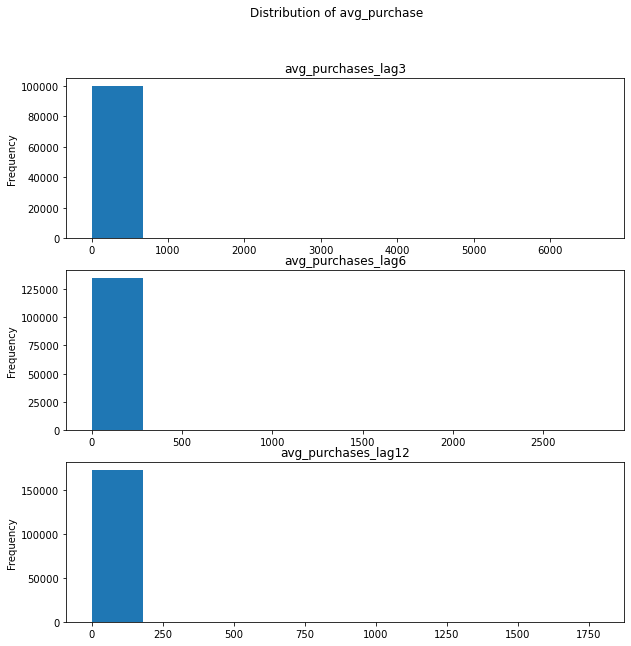

In [113]:
kind_plot = 'hist'
title_plot = 'avg_purchase'
plot_withkind(df_merchant, kind_plot, title_plot, m_purchase_features, True)

The avg_purchase_lag3, 6 and 12 features have very similar distributions.

### 2.2.4 Exploring more recent sales and purchase ranges

In [114]:
m_recent_range_features = ['most_recent_sales_range', 'most_recent_purchases_range']
df_merchant[m_recent_range_features].describe()

,most_recent_sales_range,most_recent_purchases_range
count,334696.000000,334696.000000
mean,3.388233,3.382565
std,0.753297,0.752935
min,0.000000,0.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,4.000000,4.000000
max,4.000000,4.000000


The description shows that their min, first, second and third quartiles and max values are same. Let's visualise these features.

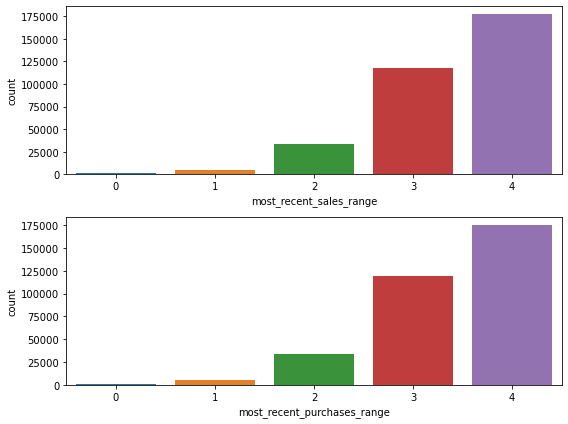

In [115]:
plot_discret_barplot(df_merchant, merchant_name, m_recent_range_features)

### 2.2.5 Explore active months

In [116]:
m_active_months_features = ['active_months_lag3', 'active_months_lag6', 'active_months_lag12']
df_merchant[m_active_months_features].describe()

,active_months_lag3,active_months_lag6,active_months_lag12
count,334696.000000,334696.000000,334696.000000
mean,2.994108,5.947397,11.599335
std,0.095247,0.394936,1.520138
min,1.000000,1.000000,1.000000
25%,3.000000,6.000000,12.000000
50%,3.000000,6.000000,12.000000
75%,3.000000,6.000000,12.000000
max,3.000000,6.000000,12.000000


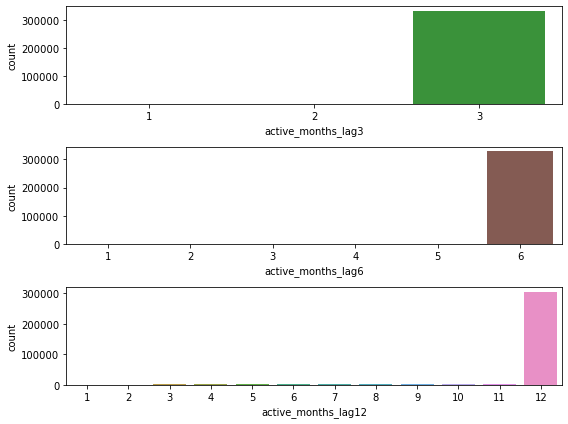

In [117]:
plot_discret_barplot(df_merchant, merchant_name, m_active_months_features)

These features do not give valuable information about merchants.

### 2.2.6 Correlation

We will look at correlation matrix and heatmap of the merchant dataset.

In [118]:
df_merchant.corr()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
merchant_group_id,1.000000,-0.015599,0.087288,-0.057871,-0.057829,0.032158,-0.148538,-0.113797,-0.002750,-0.002819,...,-0.001727,-0.003128,-0.004524,-0.001189,-0.003409,-0.003478,0.123028,-0.091952,-0.032902,-0.011018
merchant_category_id,-0.015599,1.000000,-0.004112,-0.002459,-0.002711,-0.003885,-0.044955,-0.077078,0.000554,-0.001574,...,0.001036,-0.001304,-0.009388,0.000800,-0.001026,-0.018072,-0.017626,-0.004951,0.009357,0.020021
subsector_id,0.087288,-0.004112,1.000000,0.004493,0.005594,-0.050067,0.031244,-0.157683,-0.000941,0.000517,...,-0.001508,0.000878,-0.002241,-0.001766,0.001238,-0.015790,0.048713,-0.015259,0.015125,-0.001699
numerical_1,-0.057871,-0.002459,0.004493,1.000000,0.998749,-0.002815,-0.166899,-0.161665,-0.000334,-0.000307,...,-0.000326,-0.000402,0.008177,-0.000288,-0.000487,0.016001,0.008670,-0.009856,-0.000882,-0.003953
numerical_2,-0.057829,-0.002711,0.005594,0.998749,1.000000,-0.002630,-0.164273,-0.159726,-0.000326,-0.000300,...,-0.000318,-0.000393,0.008038,-0.000281,-0.000477,0.015758,0.007627,-0.009436,-0.001072,-0.004160
category_1,0.032158,-0.003885,-0.050067,-0.002815,-0.002630,1.000000,-0.057434,0.031530,-0.000413,0.005702,...,-0.000417,0.006117,-0.017859,-0.000391,0.006430,-0.019338,0.230949,-0.142228,-0.305175,-0.288315
most_recent_sales_range,-0.148538,-0.044955,0.031244,-0.166899,-0.164273,-0.057434,1.000000,0.724153,0.004354,0.004259,...,0.004250,0.005612,-0.049007,0.003746,0.006835,-0.097149,-0.087152,0.005586,0.038600,0.012266
most_recent_purchases_range,-0.113797,-0.077078,-0.157683,-0.161665,-0.159726,0.031530,0.724153,1.000000,0.004389,0.004293,...,0.004285,0.005699,-0.049882,0.003777,0.006937,-0.095762,-0.069839,-0.023396,0.010594,0.019798
avg_sales_lag3,-0.002750,0.000554,-0.000941,-0.000334,-0.000326,-0.000413,0.004354,0.004389,1.000000,0.616581,...,0.818022,0.615270,-0.001523,0.634283,0.612145,-0.005169,-0.000317,-0.001290,-0.000140,-0.001893
avg_purchases_lag3,-0.002819,-0.001574,0.000517,-0.000307,-0.000300,0.005702,0.004259,0.004293,0.616581,1.000000,...,0.339470,0.999155,-0.000392,0.228504,0.997392,-0.002716,0.003646,-0.002170,-0.002125,-0.003665


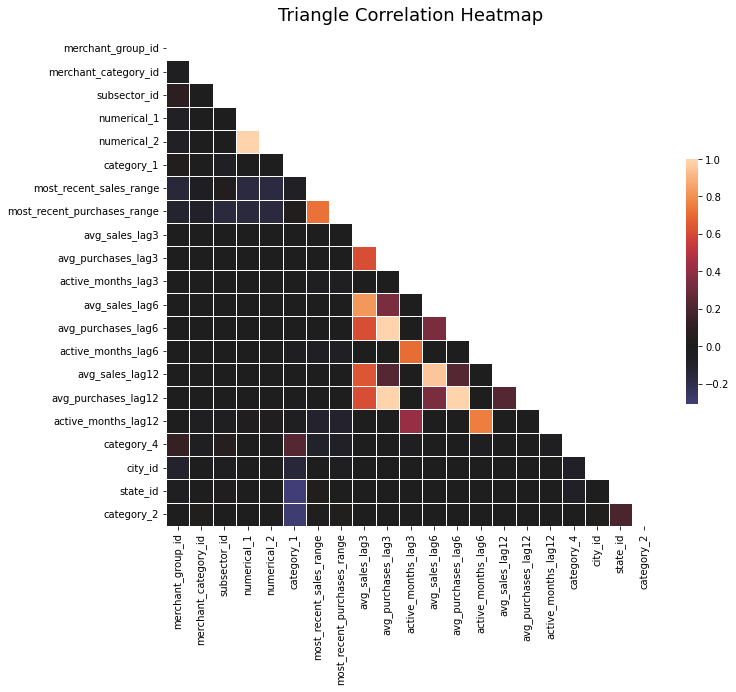

In [119]:
plot_heatmap(df_merchant)

Most correlated features:

Strong correlation:
- numerical_1 - numerical_2 -> 0.999
- avg_purchase_lag6 - avg_purchase_lag3 -> 0.999
- avg_purchase_lag12 - avg_purchase_lag3 -> 0.997
- avg_sales_lag6 - avg_sales_lag3 -> 0.958
- avg_sales_lag6 - avg_sales_lag3 -> 0.818
- active_months_lag12 - active_months_lag6 -> 0.755
- most_recent_sales_range - most_recent_purchase_range -> 0.723
- active_months_lag3 - active_months_lag6 -> 0.703

Moderate correlation
- avg_sales_lag12 - avg_sales_lag3 -> 0.634

### 2.2.7 Feature Engineering

In [120]:
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,334696.000000,...,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.832993,2.145143,...,2.165079e+01,2.390194,5.947397,2.522771e+01,2.529277,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489999,213.955844,...,3.947108e+03,194.324264,0.394936,5.251842e+03,174.419034,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,-82.130000,0.333495,...,-8.213000e+01,0.167045,1.000000,-8.213000e+01,0.098330,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,0.923650,...,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667,...,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522,...,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,61851.333333,...,1.513959e+06,56077.500000,6.000000,2.567408e+06,50215.555556,12.000000,1.000000,347.000000,24.000000,5.000000


In [121]:
df_merchant[df_merchant['avg_sales_lag3']< 0]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,0,4,4,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,0,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,0,4,4,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,0,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,0,4,4,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,0,-1,5,5.0


avg_purchase_lag3, 6, 12 and avg_sales_lag3, 6, 12 should be positive.

In [122]:

for column in m_sales_features:
    df_merchant.loc[df_merchant[column]< 0, column] = 0

In [123]:
df_merchant.describe()

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,334696.000000,...,3.346830e+05,334696.000000,334696.000000,3.346830e+05,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000
mean,31028.736143,423.131663,25.116404,0.011476,0.008103,0.021031,3.388233,3.382565,13.833241,2.145143,...,2.165104e+01,2.390194,5.947397,2.522796e+01,2.529277,11.599335,0.287126,102.917926,11.860942,2.259958
std,31623.043426,252.898046,9.807371,1.098154,1.070497,0.143488,0.753297,0.752935,2395.489993,213.955844,...,3.947108e+03,194.324264,0.394936,5.251842e+03,174.419034,1.520138,0.452422,107.090673,6.176889,1.657263
min,1.000000,-1.000000,-1.000000,-0.057471,-0.057471,0.000000,0.000000,0.000000,0.000000,0.333495,...,0.000000e+00,0.167045,1.000000,0.000000e+00,0.098330,1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,3612.000000,222.000000,19.000000,-0.057471,-0.057471,0.000000,3.000000,3.000000,0.880000,0.923650,...,8.500000e-01,0.902247,6.000000,8.500000e-01,0.898333,12.000000,0.000000,-1.000000,9.000000,1.000000
50%,19900.000000,373.000000,27.000000,-0.057471,-0.057471,0.000000,4.000000,4.000000,1.000000,1.016667,...,1.010000e+00,1.026961,6.000000,1.020000e+00,1.043361,12.000000,0.000000,69.000000,9.000000,1.000000
75%,51707.250000,683.000000,33.000000,-0.047556,-0.047556,0.000000,4.000000,4.000000,1.160000,1.146522,...,1.230000e+00,1.215575,6.000000,1.290000e+00,1.266480,12.000000,1.000000,182.000000,16.000000,4.000000
max,112586.000000,891.000000,41.000000,183.735111,182.079322,1.000000,4.000000,4.000000,851844.640000,61851.333333,...,1.513959e+06,56077.500000,6.000000,2.567408e+06,50215.555556,12.000000,1.000000,347.000000,24.000000,5.000000


In [124]:
nans(df_merchant)

merchant_id                     0
merchant_group_id               0
merchant_category_id            0
subsector_id                    0
numerical_1                     0
numerical_2                     0
category_1                      0
most_recent_sales_range         0
most_recent_purchases_range     0
avg_sales_lag3                 13
avg_purchases_lag3              0
active_months_lag3              0
avg_sales_lag6                 13
avg_purchases_lag6              0
active_months_lag6              0
avg_sales_lag12                13
avg_purchases_lag12             0
active_months_lag12             0
category_4                      0
city_id                         0
state_id                        0
category_2                      0
dtype: int64

In [125]:
df_merchant = reformat_dataframe(df_merchant, merchants_numeric_cols, lambda df: df.fillna(df.mean()))
nans(df_merchant)

merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_lag3             0
active_months_lag3             0
avg_sales_lag6                 0
avg_purchases_lag6             0
active_months_lag6             0
avg_sales_lag12                0
avg_purchases_lag12            0
active_months_lag12            0
category_4                     0
city_id                        0
state_id                       0
category_2                     0
dtype: int64

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

HYPERPARAMETER = {
    'model':LogisticRegression(),
    'onehot':[],
    'exclude':[],
    'feature':str
}
def encoder(df:pd.DataFrame, column:str):
    lb = LabelEncoder()
    df[column] = lb.fit_transform(df[column])

def fillna_withpredict(df:pd.DataFrame, parameter:HYPERPARAMETER):
    tmp = pd.DataFrame()
    columns = list()
    predict_feature = parameter['feature']
    for column in df.columns:
        if column not in parameter['exclude']:
            tmp[column] = df[column]
            columns.append(column)
    for column  in parameter['onehot']:
        encoder(tmp,column)
    test = tmp[tmp[predict_feature].isna()]
    train = tmp.dropna()
    seed = 17
    n_folds = 5
    sKFold = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = seed)
    if parameter['model'] == LogisticRegression():
        grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
        model = LogisticRegression()
        grid_cv = GridSearchCV(model, grid, cv = sKFold)
        grid_cv.fit(train[columns], train[predict_feature])
        best_params = grid_cv.best_params
        model.fit(train[columns], train[predict_feature], C = best_params['C'], penalty = best_params['penalty'])
        df.loc[df[predict_feature].isna(), predict_feature] = model.predict(test[columns])
    else:
        k_range = list(range(1, 31))
        model = KNeighborsClassifier()
        param_grid = dict(n_neighbors=k_range)
        grid_cv = GridSearchCV(model, param_grid, cv= sKFold)
        grid_cv.fit(train[columns], train[predict_feature])
        best_params = grid_cv.best_params
        model.fit(train[columns], train[predict_feature], n_neighbors = best_params['n_neighbors'])
        df.loc[df[predict_feature].isna(), predict_feature] = model.predict(test[columns])






# 2.3 History Transaction and New Merchant Transaction Data Purge

These two datasets will be purged all together because they are highly relevant. In order to process the datasets efficiently we will use a StreamerBuilder to process the data chunk by chunk

In [136]:

chunksize=10 ** 6

def histories_builder() -> StreamerBuilder[pd.DataFrame] :
    return StreamerBuilder.build(pd.read_csv(os.path.join(DATA_DIR, "historical_transactions.csv"),
                       chunksize=chunksize))

def append_df(df1, df2):
    return df1.append(df2)

def sum_df(df1, df2):
    return df1.add(df2)



In [137]:
df_new_merchants = pd.read_csv(os.path.join(DATA_DIR, "new_merchant_transactions.csv"), parse_dates=["purchase_date"])
df_new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int64         
 3   category_1            object        
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 209.7+ MB


In [138]:
df_new_merchants.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [139]:
nans(df_new_merchants)

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

category_3, category_2 and merchant_id features have missing values.

## 2.3.1 Exploring category_1, 2 and 3

In [140]:
nm_categorical_features = ['category_1', 'category_2', 'category_3']
for column in nm_categorical_features:
    print(f'Unique features of {column} : {df_new_merchants[column].unique()}')

Unique features of category_1 : ['N' 'Y']
Unique features of category_2 : [ 1. nan  3.  2.  4.  5.]
Unique features of category_3 : ['B' nan 'C' 'A']


In [141]:
df_new_merchants['category_2'].fillna(-1, inplace=True)
df_new_merchants['category_3'].fillna('D', inplace= True)

In [142]:
nans(df_new_merchants)

authorized_flag             0
card_id                     0
city_id                     0
category_1                  0
installments                0
category_3                  0
merchant_category_id        0
merchant_id             26216
month_lag                   0
purchase_amount             0
purchase_date               0
category_2                  0
state_id                    0
subsector_id                0
dtype: int64

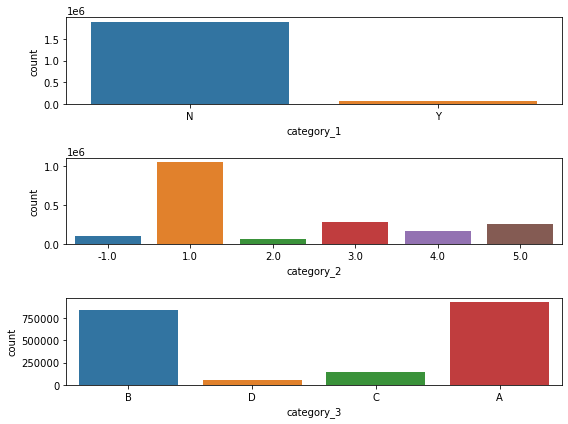

In [143]:
new_merchant_name = 'new_merchant'

plot_discret_barplot(df_new_merchants, new_merchant_name, nm_categorical_features)

Values of category_1 mostly consists of N, values of category_2 1.0 and values of category_3 A and B values.

## 2.3.2 Authorized Flag Feature

In [144]:

nm_authorized_feature = ['authorized_flag']
df_new_merchants[nm_authorized_feature].describe()

,authorized_flag
count,1963031
unique,1
top,Y
freq,1963031


All new transactions are made authorized.

### 2.3.3 Installment Feature

In [145]:
nm_installment_feature = ['installments']
print(f'Unique of the  feature {df_new_merchants[nm_installment_feature].nunique()}')
print(df_new_merchants[nm_installment_feature].value_counts())

Unique of the  feature installments    15
dtype: int64
installments
 0              922244
 1              836178
-1               55922
 2               54729
 3               44750
 4               14815
 6               10389
 5                9296
 10               8899
 12               2850
 8                1555
 7                 863
 9                 478
 11                 61
 999                 2
dtype: int64


The values 999 and -1 for the installments are not possible. It seems that they are outlier.

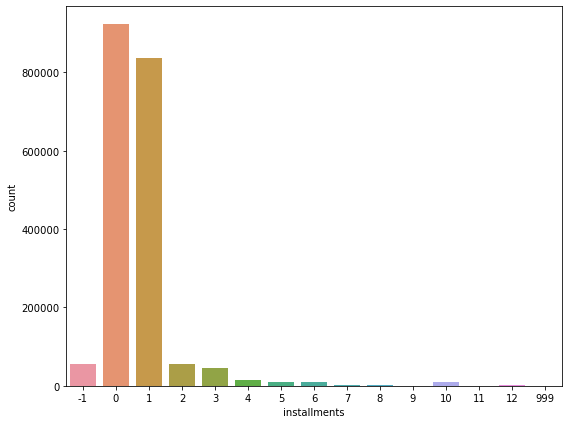

In [146]:
plot_discret_barplot(df_new_merchants, new_merchant_name, nm_installment_feature)

The most of the transactions are made with short term installments or instant payments.

### 2.3.4 Explore purchase_date feature

In [147]:
def plot_year_month_of_data(df:pd.DataFrame, feature_name:str):
    """
    plot the transaction over the years and months.
    Args:
        df: dataset which is plotted.
        feature_name: which feature should be plotted.

    Returns:

    """
    # Plot transactions over years
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    sns.countplot(x = df[feature_name].dt.year)
    plt.title('Distribution of the transaction over years')
    # Plot transactions over months
    plt.subplot(122)
    sns.countplot(x = df[feature_name].dt.month)
    plt.title('Distribution of the transaction over months')
    plt.tight_layout
    plt.show()

def plot_days_hours_of_data(df:pd.DataFrame, feature_name:str):
    """
    plot the transaction over the days.
    Args:
        df: dataset which is plotted.
        feature_name: which feature should be plotted.

    Returns:

    """
    #days
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    sns.countplot(x = df[feature_name].dt.dayofweek)
    plt.title("Distribution of the transactions over days")
    days_of_week = ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']
    plt.xlabel('Days')
    plt.xticks(range(7), labels= days_of_week)
    # hour
    plt.subplot(122)
    sns.countplot(x = df[feature_name].dt.hour)
    plt.title('Distribution of the transaction over hours')
    plt.xticks(range(24))
    plt.xlabel('Hour')
    plt.show()

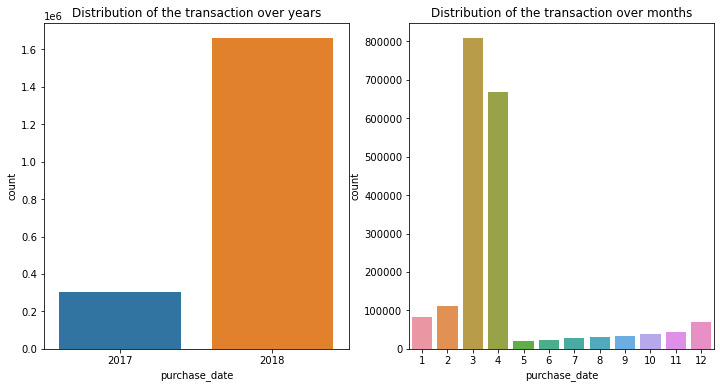

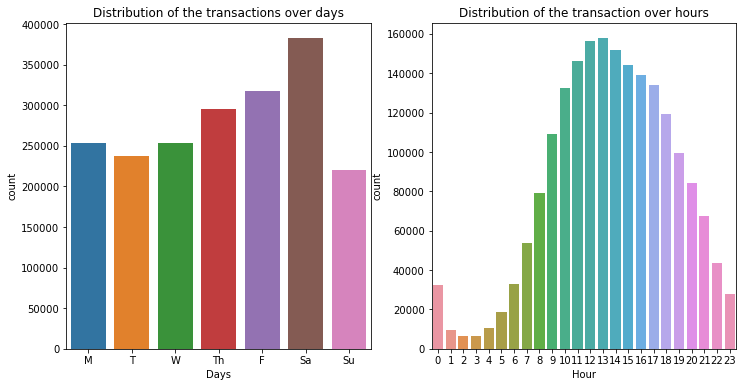

In [148]:
nm_purchase_date = ['purchase_date']
plot_year_month_of_data(df_new_merchants, 'purchase_date')
plot_days_hours_of_data(df_new_merchants, 'purchase_date')

Maximum number of purchases are made in 2018. Furthermore, purchases take place at noon. Moreover, they increase from Tuesday to Saturday.

### 2.3.5 Correlation between features in new_merchant dataset

In [149]:
df_new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   authorized_flag       object        
 1   card_id               object        
 2   city_id               int64         
 3   category_1            object        
 4   installments          int64         
 5   category_3            object        
 6   merchant_category_id  int64         
 7   merchant_id           object        
 8   month_lag             int64         
 9   purchase_amount       float64       
 10  purchase_date         datetime64[ns]
 11  category_2            float64       
 12  state_id              int64         
 13  subsector_id          int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 209.7+ MB


In [150]:
nm_numerical_features = list()
for key, value in dict(df_new_merchants.dtypes).items():
    if value in ['int64', 'float64']:
        nm_numerical_features.append(key)
print(nm_numerical_features)

['city_id', 'installments', 'merchant_category_id', 'month_lag', 'purchase_amount', 'category_2', 'state_id', 'subsector_id']


In [151]:
# add categorical values as numerical to enable to correlate
df_tmp_new_merchant = df_new_merchants[nm_numerical_features]

category_3_values = {'A':1,'B':2,'C':3,'D':4}

df_tmp_new_merchant["category_3"] = df_new_merchants['category_3'].map(category_3_values)
df_tmp_new_merchant.dropna()

/Users/adsiz/opt/anaconda3/envs/lama/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id,category_3
0,107,1,307,1,-0.557574,1.0,9,19,2
1,140,1,307,1,-0.569580,1.0,9,19,2
2,330,1,507,2,-0.551037,1.0,9,14,2
3,-1,1,661,1,-0.671925,-1.0,-1,8,2
4,-1,1,166,1,-0.659904,-1.0,-1,29,2
...,...,...,...,...,...,...,...,...,...
1963026,142,0,309,2,-0.701828,3.0,19,21,1
1963027,158,0,560,2,-0.694390,1.0,15,34,1
1963028,69,1,278,1,-0.621031,1.0,9,37,2
1963029,130,0,367,1,-0.656749,3.0,7,16,1


In [152]:
df_tmp_new_merchant.corr()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id,category_3
city_id,1.000000,-0.053698,-0.043561,-0.000413,-0.023166,0.192597,0.109207,0.012631,-0.057298
installments,-0.053698,1.000000,0.053837,-0.005600,0.206971,-0.065967,-0.074535,-0.070943,0.391959
merchant_category_id,-0.043561,0.053837,1.000000,-0.003366,0.015988,-0.057808,-0.056976,-0.109032,0.032555
month_lag,-0.000413,-0.005600,-0.003366,1.000000,0.001898,-0.002121,-0.005599,0.004876,0.003066
purchase_amount,-0.023166,0.206971,0.015988,0.001898,1.000000,-0.018728,-0.034345,-0.097880,0.225303
category_2,0.192597,-0.065967,-0.057808,-0.002121,-0.018728,1.000000,0.328250,0.046197,-0.058937
state_id,0.109207,-0.074535,-0.056976,-0.005599,-0.034345,0.328250,1.000000,0.051893,-0.070757
subsector_id,0.012631,-0.070943,-0.109032,0.004876,-0.097880,0.046197,0.051893,1.000000,-0.081134
category_3,-0.057298,0.391959,0.032555,0.003066,0.225303,-0.058937,-0.070757,-0.081134,1.000000


43813

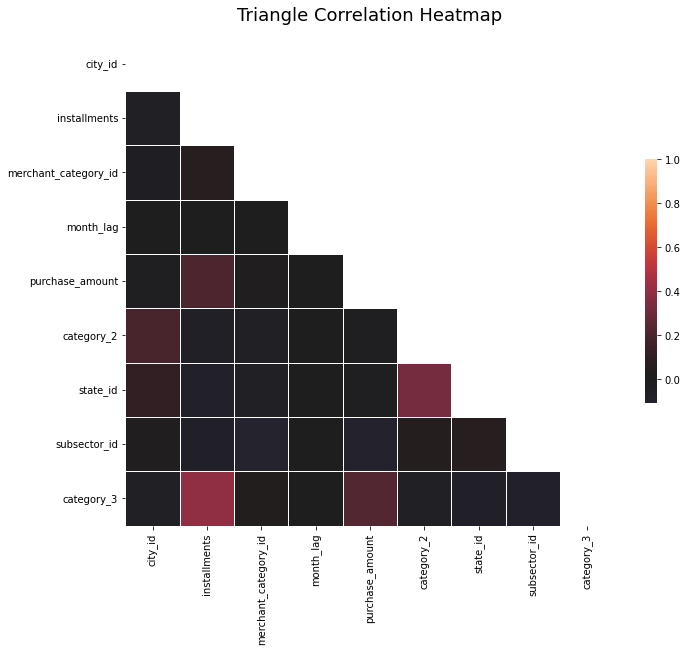

In [153]:
plot_heatmap(df_tmp_new_merchant)
del df_tmp_new_merchant
gc.collect()

category_3-installment -> weak correlation

state_id - category_2 -> weak correlation

We will firstly check the duplicate columns

In [154]:
duplicate_cols = []

for col in df_new_merchants.columns:
    if col in df_merchant.columns:
        duplicate_cols.append(col)

duplicate_cols = ['merchant_id', 'city_id', 'category_1', 'merchant_category_id', 'category_2', 'state_id', 'subsector_id']
df_merchant = df_merchant.drop(duplicate_cols[1:], axis=1)
df_merchant = df_merchant.loc[df_merchant['merchant_id'].drop_duplicates().index]
df_merchant.to_csv(os.path.join(OUT_DIR, 'merchants_pre.csv'), index=False)

In [155]:
df_new_merchants[duplicate_cols].drop_duplicates().shape

(291242, 7)

We then merge merchants_pre table to our transactions table

In [156]:
print(df_new_merchants['merchant_id'].nunique())
cols = ['most_recent_sales_range', 'most_recent_purchases_range', 'numerical_1', 'numerical_2', 'merchant_id']
df_new_merchants = df_new_merchants.merge(df_merchant[cols], how='left', on='merchant_id')

226129


In [157]:
nans(df_new_merchants)

authorized_flag                    0
card_id                            0
city_id                            0
category_1                         0
installments                       0
category_3                         0
merchant_category_id               0
merchant_id                    26216
month_lag                          0
purchase_amount                    0
purchase_date                      0
category_2                         0
state_id                           0
subsector_id                       0
most_recent_sales_range        26216
most_recent_purchases_range    26216
numerical_1                    26216
numerical_2                    26216
dtype: int64

In [158]:
print(df_new_merchants.info())
df_new_merchants.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963031 entries, 0 to 1963030
Data columns (total 18 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   authorized_flag              object        
 1   card_id                      object        
 2   city_id                      int64         
 3   category_1                   object        
 4   installments                 int64         
 5   category_3                   object        
 6   merchant_category_id         int64         
 7   merchant_id                  object        
 8   month_lag                    int64         
 9   purchase_amount              float64       
 10  purchase_date                datetime64[ns]
 11  category_2                   float64       
 12  state_id                     int64         
 13  subsector_id                 int64         
 14  most_recent_sales_range      float64       
 15  most_recent_purchases_range  float64       
 16  

,city_id,installments,merchant_category_id,month_lag,purchase_amount,category_2,state_id,subsector_id,most_recent_sales_range,most_recent_purchases_range,numerical_1,numerical_2
count,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.963031e+06,1.936815e+06,1.936815e+06,1.936815e+06,1.936815e+06
mean,1.343867e+02,6.829643e-01,4.309701e+02,1.476515e+00,-5.509690e-01,2.015805e+00,1.088067e+01,2.597624e+01,1.968008e+00,1.929191e+00,3.476201e+00,3.391298e+00
std,1.015152e+02,1.584069e+00,2.463385e+02,4.994483e-01,6.940043e-01,1.658681e+00,6.038542e+00,1.012908e+01,1.277583e+00,1.261135e+00,1.658890e+01,1.641464e+01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00,-7.468928e-01,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-5.747065e-02,-5.747065e-02
25%,6.900000e+01,0.000000e+00,2.780000e+02,1.000000e+00,-7.166294e-01,1.000000e+00,9.000000e+00,1.900000e+01,1.000000e+00,1.000000e+00,-5.747065e-02,-5.747065e-02
50%,1.100000e+02,1.000000e+00,3.670000e+02,1.000000e+00,-6.748406e-01,1.000000e+00,9.000000e+00,2.900000e+01,2.000000e+00,2.000000e+00,-3.764084e-02,-5.747065e-02
75%,2.120000e+02,1.000000e+00,6.830000e+02,2.000000e+00,-5.816162e-01,3.000000e+00,1.500000e+01,3.400000e+01,3.000000e+00,3.000000e+00,2.003169e-01,3.176349e-02
max,3.470000e+02,9.990000e+02,8.910000e+02,2.000000e+00,2.631575e+02,5.000000e+00,2.400000e+01,4.100000e+01,4.000000e+00,4.000000e+00,1.837351e+02,1.820793e+02


In [159]:
# print(df_new_merchants.info())
# df_new_merchants.describe()

In [160]:
transactions_numeric = ['month_lag', 'installments', 'purchase_amount', 'numerical_1', 'numerical_2']
transactions_category = ['card_id', 'authorized_flag', 'category_3', 'category_1', 'merchant_category_id', 'subsector_id', 'merchant_id', 'city_id', "state_id", 'category_2', 'most_recent_sales_range', 'most_recent_purchases_range']
# reserved for time series model
transactions_time_cols = ['purchase_date']


assert len(df_new_merchants.columns) == len(transactions_category) + len(transactions_numeric) + len(transactions_time_cols)

In [161]:
df_new_merchants[transactions_category].dtypes

card_id                         object
authorized_flag                 object
category_3                      object
category_1                      object
merchant_category_id             int64
subsector_id                     int64
merchant_id                     object
city_id                          int64
state_id                         int64
category_2                     float64
most_recent_sales_range        float64
most_recent_purchases_range    float64
dtype: object

In [162]:
df_new_merchants[transactions_numeric].dtypes

month_lag            int64
installments         int64
purchase_amount    float64
numerical_1        float64
numerical_2        float64
dtype: object

In [163]:
nans(df_new_merchants)

authorized_flag                    0
card_id                            0
city_id                            0
category_1                         0
installments                       0
category_3                         0
merchant_category_id               0
merchant_id                    26216
month_lag                          0
purchase_amount                    0
purchase_date                      0
category_2                         0
state_id                           0
subsector_id                       0
most_recent_sales_range        26216
most_recent_purchases_range    26216
numerical_1                    26216
numerical_2                    26216
dtype: int64

In [164]:
features = ['authorized_flag', 'category_1', 'category_3']
df_new_merchants = reformat_dataframe(df_new_merchants, features, change_object_col)


# convert dtype to small int
df_new_merchants['category_2'].fillna(-1, inplace=True)
df_new_merchants['category_2'] = df_new_merchants['category_2'].astype(np.int8)
df_new_merchants['category_1'] = df_new_merchants['category_1'].astype(np.int8)
df_new_merchants['authorized_flag'] = df_new_merchants['authorized_flag'].astype(np.int8)
df_new_merchants['installments'] = df_new_merchants['installments'].astype(np.int8)
df_new_merchants['state_id'] = df_new_merchants['state_id'].astype(np.int8)
df_new_merchants['city_id'] = df_new_merchants['city_id'].astype(np.int8)
df_new_merchants['subsector_id'] = df_new_merchants['subsector_id'].astype(np.int8)

In [165]:
# convert purchase date to timeseries
datetime_index = pd.DatetimeIndex(df_new_merchants['purchase_date'])
df_new_merchants.info()
transactions_dtype = df_new_merchants.dtypes
df_new_merchants['purchase_day'] = datetime_index.day
df_new_merchants['purchase_month'] = datetime_index.month
df_new_merchants['purchase_year'] = datetime_index.year
df_new_merchants['purchase_hour_section'] = datetime_index.time

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963031 entries, 0 to 1963030
Data columns (total 18 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   authorized_flag              int8          
 1   card_id                      object        
 2   city_id                      int8          
 3   category_1                   int8          
 4   installments                 int8          
 5   category_3                   int64         
 6   merchant_category_id         int64         
 7   merchant_id                  object        
 8   month_lag                    int64         
 9   purchase_amount              float64       
 10  purchase_date                datetime64[ns]
 11  category_2                   int8          
 12  state_id                     int8          
 13  subsector_id                 int8          
 14  most_recent_sales_range      float64       
 15  most_recent_purchases_range  float64       
 16  

In [166]:
df_new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963031 entries, 0 to 1963030
Data columns (total 22 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   authorized_flag              int8          
 1   card_id                      object        
 2   city_id                      int8          
 3   category_1                   int8          
 4   installments                 int8          
 5   category_3                   int64         
 6   merchant_category_id         int64         
 7   merchant_id                  object        
 8   month_lag                    int64         
 9   purchase_amount              float64       
 10  purchase_date                datetime64[ns]
 11  category_2                   int8          
 12  state_id                     int8          
 13  subsector_id                 int8          
 14  most_recent_sales_range      float64       
 15  most_recent_purchases_range  float64       
 16  

In [167]:
df_new_merchants['purchase_date'] = df_new_merchants['purchase_date'].astype(object)

In [168]:
df_new_merchants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963031 entries, 0 to 1963030
Data columns (total 22 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   authorized_flag              int8   
 1   card_id                      object 
 2   city_id                      int8   
 3   category_1                   int8   
 4   installments                 int8   
 5   category_3                   int64  
 6   merchant_category_id         int64  
 7   merchant_id                  object 
 8   month_lag                    int64  
 9   purchase_amount              float64
 10  purchase_date                object 
 11  category_2                   int8   
 12  state_id                     int8   
 13  subsector_id                 int8   
 14  most_recent_sales_range      float64
 15  most_recent_purchases_range  float64
 16  numerical_1                  float64
 17  numerical_2                  float64
 18  purchase_day                 int64  
 19  

In [169]:

transactions_features = df_new_merchants.columns
transactions_path = os.path.join(OUT_DIR, 'transactions_pre.csv')
if os.path.exists(transactions_path):
    os.remove(transactions_path)
df_new_merchants.to_csv(transactions_path, mode='a', index=False)

There is no need to fill numerical columns since they don't have nans

In [170]:
histories_nans = histories_builder().map(nans).reduce(sum_df).collect(identity)
print(histories_nans)

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64


In [171]:
# reserved for large memory write-ins
del df_new_merchants, datetime_index
gc.collect()

199

As we can discover the history columns and new merchants columns are the same, so we can easily using the above methods again.

In [172]:
def add_datetime_index(df: pd.DataFrame):
    _datetime_index = pd.DatetimeIndex(df['purchase_date'])
    df['purchase_day'] = _datetime_index.day
    df['purchase_month'] = _datetime_index.month
    df['purchase_year'] = _datetime_index.year
    df['purchase_hour_section'] = _datetime_index.time
    return df

def convert_columns(df: pd.DataFrame):
    df['category_2'].fillna(-1, inplace=True)
    return df

to_csv_builder = histories_builder() \
                    .map(lambda df: reformat_dataframe(df, features, change_object_col)) \
                    .map(lambda df: df.merge(df_merchant[cols], how='left', on='merchant_id')) \
                    .map(convert_columns) \
                    .map(add_datetime_index)

# write to csv
to_csv_builder.consume(lambda df: df.to_csv(transactions_path, mode='a', index=False, header=False))

del to_csv_builder


# 3 Features Engineering

We will extract each columns by their numerical features and append them to the end

In [173]:
def create_aggs_cols() -> t.Tuple[t.Dict[str, str], t.List[str]]:
    aggs = {}
    for col in transactions_numeric:
        aggs[col] = ['nunique', 'mean', 'min', 'max', 'var', 'skew', 'sum']
    for col in transactions_category:
        aggs[col] = ['nunique']
    aggs['card_id'] = ['size', 'count']
    cols = []
    for key in aggs.keys():
        cols.extend([key+"_"+stat for stat in aggs[key]])
    return aggs, cols

In [174]:

@enable_logging("append_new_columns.log")
def append_new_columns(transaction, aggs, cols):
    df = transaction[transaction['month_lag'] < 0].groupby('card_id').agg(aggs)
    df.columns = [co + "_hist" for co in cols]
    df2 = transaction[transaction['month_lag'] >= 0].groupby('card_id').agg(aggs)
    df2.columns =[co + "_hist" for co in cols]
    df = df.reset_index()
    df2 = df2.reset_index()
    df = df.merge(df2, how='left', on='card_id')
    df2 = transaction.groupby('card_id').agg(aggs)
    df2.columns = cols
    df2 = df2.reset_index()
    if not df.empty:
        df = df.merge(df2, how='left', on='card_id')
    else:
        df = df2.copy()
    del transaction
    gc.collect()
    return df

@enable_logging("to_train_test.log")
def to_train_test(df):
    train = pd.read_csv(os.path.join(OUT_DIR, "train_pre.csv"))
    train = train.merge(df, how='left', on='card_id')
    logging.debug(f'Training df after first merge')

    test = pd.read_csv(os.path.join(OUT_DIR, "test_pre.csv"))
    test = test.merge(df, how='left', on='card_id')
    return train, test

@enable_logging("write_to_csv.log")
def write_to_csv(train, test):
    train.to_csv(os.path.join(OUT_DIR, "train_groupby.csv"), index=False, mode='a')
    test.to_csv(os.path.join(OUT_DIR, "test_groupby.csv"), index=False, mode='a')
    gc.collect()


The Following block is extremely time-consuming, run with caution.

In [175]:
train_groupby, test_groupby = os.path.join(OUT_DIR, "train_groupby.csv"), os.path.join(OUT_DIR, "test_groupby.csv")
if os.path.exists(train_groupby):
    os.remove(train_groupby)
if os.path.exists(test_groupby):
    os.remove(test_groupby)

aggs, cols = create_aggs_cols()

dtype = transactions_dtype.to_dict()
dtype['purchase_date'] = dtype('int64[ns]')

In [178]:
transactions = pd.read_csv(os.path.join(OUT_DIR, "transactions_pre.csv"))

In [179]:
# we will use dtypes collected from previous to save memory
#transactions = pd.read_csv(os.path.join(OUT_DIR, "transactions_pre.csv"), dtype=dtype)
transactions = append_new_columns(transactions, aggs, cols)
train, test = to_train_test(transactions)

In [180]:
print(dtype)

{'authorized_flag': dtype('int8'), 'card_id': dtype('O'), 'city_id': dtype('int8'), 'category_1': dtype('int8'), 'installments': dtype('int8'), 'category_3': dtype('int64'), 'merchant_category_id': dtype('int64'), 'merchant_id': dtype('O'), 'month_lag': dtype('int64'), 'purchase_amount': dtype('float64'), 'purchase_date': dtype('<M8[ns]'), 'category_2': dtype('int8'), 'state_id': dtype('int8'), 'subsector_id': dtype('int8'), 'most_recent_sales_range': dtype('float64'), 'most_recent_purchases_range': dtype('float64'), 'numerical_1': dtype('float64'), 'numerical_2': dtype('float64')}


In [181]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month_lag_nunique_hist_x,month_lag_mean_hist_x,month_lag_min_hist_x,month_lag_max_hist_x,...,category_3_nunique,category_1_nunique,merchant_category_id_nunique,subsector_id_nunique,merchant_id_nunique,city_id_nunique,state_id_nunique,category_2_nunique,most_recent_sales_range_nunique,most_recent_purchases_range_nunique
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,8,-4.291139,-8,-1,...,2,1,46,21,117,9,3,2,5,5
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,12,-5.889632,-12,-1,...,3,2,58,24,148,9,3,2,5,5
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,11,-8.809524,-13,-1,...,1,1,9,8,14,6,2,2,4,5
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,5,-3.573770,-5,-1,...,4,2,28,15,57,7,5,3,5,5
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,3,-1.744898,-3,-1,...,3,2,37,19,102,7,7,5,5,5


In [182]:
nans(train)

first_active_month                     0
card_id                                0
feature_1                              0
feature_2                              0
feature_3                              0
                                      ..
city_id_nunique                        0
state_id_nunique                       0
category_2_nunique                     0
most_recent_sales_range_nunique        0
most_recent_purchases_range_nunique    0
Length: 150, dtype: int64

In [183]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,month_lag_nunique_hist_x,month_lag_mean_hist_x,month_lag_min_hist_x,month_lag_max_hist_x,month_lag_var_hist_x,...,category_3_nunique,category_1_nunique,merchant_category_id_nunique,subsector_id_nunique,merchant_id_nunique,city_id_nunique,state_id_nunique,category_2_nunique,most_recent_sales_range_nunique,most_recent_purchases_range_nunique
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,8,-4.258621,-8,-1,4.370538,...,2,2,17,13,27,8,3,2,5,5
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,5,-10.684211,-13,-9,1.845614,...,2,2,22,15,36,4,3,3,5,5
2,2017-08-01,C_ID_b709037bc5,5,1,1,5,-2.700000,-6,-1,2.233333,...,3,2,9,7,11,5,5,3,4,3
3,2017-12-01,C_ID_d27d835a9f,2,1,0,2,-1.882353,-2,-1,0.110294,...,3,2,25,14,33,3,3,3,4,4
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,13,-7.873563,-13,-1,12.902433,...,3,1,33,15,53,7,4,3,5,5


In [184]:
nans(test)

first_active_month                     1
card_id                                0
feature_1                              0
feature_2                              0
feature_3                              0
                                      ..
city_id_nunique                        0
state_id_nunique                       0
category_2_nunique                     0
most_recent_sales_range_nunique        0
most_recent_purchases_range_nunique    0
Length: 149, dtype: int64

We need to reformat the dataframe sothat the dataframe is readyly used by our model

In [191]:

# print(train.describe())
features = train.columns.tolist()
features.remove('target')
print(test.describe())
print(test['first_active_month'].dtypes)
for feature in features:
    if train[feature].isnull().any():
        train[feature].fillna(train[feature].mean(), inplace=True)
    if test[feature].isnull().any():
        print(feature)
        test[feature].fillna(test[feature].mean(), inplace=True)


train.to_csv(os.path.join(OUT_DIR, "train_groupby.csv"), index=False)
test.to_csv(os.path.join(OUT_DIR, "test_groupby.csv"), index=False)

          feature_1      feature_2      feature_3  month_lag_nunique_hist_x  \
count  123623.00000  123623.000000  123623.000000             123623.000000   
mean        3.10926       1.741796       0.564377                  6.984137   
std         1.18911       0.749195       0.495840                  3.569565   
min         1.00000       1.000000       0.000000                  1.000000   
25%         2.00000       1.000000       0.000000                  4.000000   
50%         3.00000       2.000000       1.000000                  6.000000   
75%         4.00000       2.000000       1.000000                 10.000000   
max         5.00000       3.000000       1.000000                 13.000000   

       month_lag_mean_hist_x  month_lag_min_hist_x  month_lag_max_hist_x  \
count          123623.000000         123623.000000         123623.000000   
mean               -4.343226             -7.887812             -1.166239   
std                 2.100312              3.840508          

TypeError: can only concatenate str (not "int") to str